# Sledenje barže

## Primer: 2D gibanje na valovih, Teorija 1.reda

Sedaj pišem normalen tekst **odebljeno** pa še *italic*

* prvi
* drugi 
1. tretji

[to je link do googla](https://www.google.com)

$$
y(x) = a x^2 + b x +c
$$

to je jezik [LaTeX](https://www.latex-project.org) in to je grška lambda: $\lambda$

Problem description

Prva sprememba 18/03/2021.

In [1]:
import math as mat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.patches as patch
from IPython.display import HTML

In [2]:
def heave_force_amplitude(rho,g,zeta,L,D,k,A33):
    
    return g*zeta * (rho*mat.exp(-k*D)*B - k*A33*mat.exp(-k*D/2)) * 2/k * mat.sin(k*L/2)

In [3]:
def heave_amplitude(q3,ww,wn):
    
    return -q3/(1-(ww/wn)**2)

In [4]:
# w - frekvenca valovanja
# wA - amplituda valovanja
# wL - valovna dolžina valovanja
# L - dolžina barže
# D - ugrez barže
# M - masa barže
# A33 - 2D added mass za presek barže
# Aw - površina vodne linije
#
def barge_heave_amplitude(rho,g,w,wA,wL,L,D,M,A33,Aw):
    
    k = 2*mat.pi/wL
    
    f3 = heave_force_amplitude(rho,g,wA,L,D,k,A33)
    
    q3 = f3/(rho*g*Aw) 
    wn = mat.sqrt(rho*g*Aw/(M+L*A33))
    
    a3 = heave_amplitude(q3,w,wn)
    
    return [f3, wn, a3]

In [5]:
def pitch_moment_amplitude(rho,g,zeta,L,B,D,k,A33):
    
    c1 = rho*g*zeta*mat.exp(-k*D)*B
    c2 = -k*g*A33*zeta*mat.exp(-k*D/2)
    c3 = 2/k * ( L/2*mat.cos(k*L/2) - mat.sin(k*L/2)/k )
    '''
    print('c1={:.5g}, c2={:.5g}, c3={:.5g}, (c1+c2)={:.5g}'.format(c1,c2,c3,c1+c2))
    
    nn = 100
    kk = np.linspace(0.1*k,10*k,nn)
    ll = np.zeros(nn)
    pma = np.zeros(nn)
    for i in range(nn):
        ll[i] = 2/kk[i] * ( L/2*mat.cos(kk[i]*L/2) - mat.sin(kk[i]*L/2)/kk[i] )
        pma[i] = ll[i] * (rho*g*zeta*mat.exp(-kk[i]*D)*B - kk[i]*g*A33*zeta*mat.exp(-kk[i]*D/2))
        
    pfig, pax = plt.subplots()    
    pax.plot(kk,pma)
    '''
    
    return -(c1 + c2)*c3

In [6]:
def pitch_amplitude(q5,ww,wn):
    
    return q5/(1 - (ww/wn)**2)

In [7]:
# w - frekvenca valovanja
# wA - amplituda valovanja
# wL - valovna dolžina valovanja
# L - dolžina barže
# B - širina barže
# H - višina barže
# D - ugrez barže
# M - masa barže
# A33 - 2D added mass za presek barže
# Aw - površina vodne linije
#
def barge_pitch_amplitude(rho,g,w,wA,wL,L,B,H,D,M,A33,Aw):

        k = 2*mat.pi/wL
        
        f5 = pitch_moment_amplitude(rho,g,wA,L,B,D,k,A33)
        c55 = rho*g * (L**3) * B/4
        q5 = f5/c55
        I55 = rho*H*B*(L**3)/4
        A55 = A33*(L**3)/4
        
        wn = mat.sqrt(c55/(I55+A55))
        
        a5 = pitch_amplitude(q5,w,wn)
        
        return [f5, wn, a5]
        

In [8]:
def set_barge_problem(L,B,H,D,w,wA,wL):
    
    rho = 1025
    g = 9.81
    
    M = L*B*D*rho
    A33 = 0.8*rho*B*D
    Aw = L*B

    bha = barge_heave_amplitude(rho,g,w,wA,wL,L,D,M,A33,Aw)
    print('heave motion:')
    print('  -> f = {:.5f} [N]'.format(bha[0]))
    print('  -> w = {:.5f} [rad/s]'.format(bha[1]))
    print('  -> A = {:.5f} [m]'.format(bha[2])) 
    print()

    bpa = barge_pitch_amplitude(rho,g,w,wA,wL,L,B,H,D,M,A33,Aw)
    print('pitch motion:')
    print('  -> f = {:.5f} [Nm]'.format(bpa[0]))
    print('  -> w = {:.5f} [rad/s]'.format(bpa[1]))
    print('  -> A = {:.5f} [rad]'.format(bpa[2]))
    
    return [[bha[2], bha[1]], [bpa[2], bpa[1]]]

In [9]:
class UpdatePlot:
    def __init__(self, ax, L, H, D, wW, wA, wL, bd, dt=0.01):
        # inital constants 
        self.ax = ax
        self.L = L
        self.H = H
        self.D = D
        self.wW = wW
        self.wA = wA
        self.wL = wL
        self.wK = 2*mat.pi/wL
        self.hA = bd[0]
        self.pA = bd[1]
        self.dt = dt
        
        # plot parameters
        self.t = 0
        self.xL = 2*L
        self.yL = wA + mat.fabs(self.hA) + H + 1
        
        self.ax.set_xlim((-self.xL, self.xL));
        self.ax.set_ylim((-self.yL, self.yL));
        
        ratio = 2.0
        xleft, xright = self.ax.get_xlim()
        ybottom, ytop = self.ax.get_ylim()
        rr = abs((ybottom-ytop)/(xright-xleft))*ratio
        self.ax.set_aspect(rr)
        self.ax.grid(True)
        
        # generate barge corner points
        r1 = mat.sqrt((L/2)**2 + (H-D)**2)
        r2 = mat.sqrt((L/2)**2 + D**2)
        a1 = mat.atan(2*(H-D)/L)
        a2 = mat.atan(2*D/L)
        
        self.bcp = np.array([[r1,a1],[r2,a2]])

        self.wave, = self.ax.plot([-self.xL,self.xL], [0,0], lw=2, color='blue')
        self.x = np.linspace(-self.xL, self.xL, 100)
        y = self.wA*np.sin(self.wK*self.x)
        self.wave.set_data(self.x, y)

        bs = self.get_barge_points(0)
        self.barge, = self.ax.plot(bs[0], bs[1], lw=2, color='red')
        
        self.time_text = ax.text(-0.8*self.xL, 0.7*self.yL, '')
        
    def __call__(self, i):
        
        t = self.dt * i
        y = self.wA*np.sin(self.wK*self.x - self.wW*t)
        self.wave.set_data(self.x, y)
        
        bd = self.get_barge_points(t)
        self.barge.set_data(bd[0],bd[1])
        
        self.time_text.set_text('t = {:.1f}s'.format(t))
    
        return (self.wave,self.barge,self.time_text,)
        
    def get_barge_points(self,t):
                
        yh = self.hA*mat.sin(self.wW*t) # barge heave elevation [m]
        fi = self.pA*mat.cos(self.wW*t) # barge pitch angle [rad]

        x1 = self.bcp[0,0]*mat.cos(self.bcp[0,1] + fi)
        y1 = self.bcp[0,0]*mat.sin(self.bcp[0,1] + fi)
        x2 = -self.bcp[0,0]*mat.cos(self.bcp[0,1] - fi)
        y2 = self.bcp[0,0]*mat.sin(self.bcp[0,1] - fi)
        x3 = -self.bcp[1,0]*mat.cos(self.bcp[1,1] + fi)
        y3 = -self.bcp[1,0]*mat.sin(self.bcp[1,1] + fi)
        x4 = self.bcp[1,0]*mat.cos(self.bcp[1,1] - fi)
        y4 = -self.bcp[1,0]*mat.sin(self.bcp[1,1] - fi)
         
        xp = np.array([x1,x2,x3,x4,x1])
        yp = np.array([y1,y2,y3,y4,y1])

        return [xp,yp+yh]

Main function calling:
    
* set_barge_problem: gets heave and pitch amplitudes 
* sets animation view

# frames = 24
wave w = 0.7851 [rad/s]

heave motion:
  -> f = 14815410.46170 [N]
  -> w = 1.65076 [rad/s]
  -> A = -4.76024 [m]

pitch motion:
  -> f = 31877949.85305 [Nm]
  -> w = 1.21917 [rad/s]
  -> A = 0.13541 [rad]


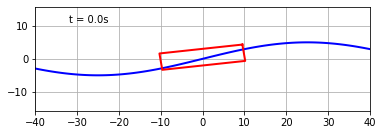

In [10]:
# barge data
L = 20
B = 20
H = 5
D = 2

# wave data
wA = 5
wL = 100
wK = 2*mat.pi/wL
T = mat.sqrt(2*mat.pi*wL/9.81)
wW = 2*mat.pi/T

# animation settings
fs = 3
ff = int(2*mat.pi/wW * fs)
print('# frames = {:d}'.format(ff))

print('wave w = {:.5g} [rad/s]\n'.format(wW))
bdp = set_barge_problem(L,B,H,D,wW,wA,wL)

fig, ax = plt.subplots()

ppud = UpdatePlot(ax, L, H, D, wW, wA, wL, [bdp[0][0],bdp[1][0]],1/fs)
anim = animation.FuncAnimation(fig, ppud, frames=ff, interval=100, blit=True)

In [11]:
HTML(anim.to_jshtml())